# Find out the inside of acc

In [1]:
import time
import os
import pandas as pd
import numpy as np
import torch
import gc
import dgl
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv
from torch.autograd import Variable
from dgl.data import DGLDataset
from sklearn.utils import shuffle
from gcn import GCN
from my_dataset import MyDataset

FileNotFoundError: Could not find module 'D:\Anaconda\lib\site-packages\dgl\dgl.dll' (or one of its dependencies). Try using the full path with constructor syntax.

In [3]:
dfTest = pd.read_csv('./test_simple.csv')
testFiles = dfTest['file_name']
testFiles[-10:-5]

2630    ../negative_graph_featureSimplified/4b6r_ligand_5
2631    ../negative_graph_featureSimplified/1os5_ligand_3
2632    ../negative_graph_featureSimplified/4dy6_ligand_7
2633    ../negative_graph_featureSimplified/1alw_ligand_2
2634    ../negative_graph_featureSimplified/1mq6_ligand_1
Name: file_name, dtype: object

In [4]:
testFiles[:5]

0    ../positive_graph_featureSimplified/1v2s
1    ../positive_graph_featureSimplified/4lxz
2    ../positive_graph_featureSimplified/4tmk
3    ../positive_graph_featureSimplified/5efh
4    ../positive_graph_featureSimplified/3ps1
Name: file_name, dtype: object

In [5]:
modelPath = '../models/gcnGAT_with_simple_feature1642648899.pkl'
model = torch.load(modelPath)
model

GCN(
  (gnn_layerList): ModuleList(
    (0): GATConv(
      (fc): Linear(in_features=34, out_features=80, bias=False)
      (feat_drop): Dropout(p=0.0, inplace=False)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (1): GATConv(
      (fc): Linear(in_features=80, out_features=160, bias=False)
      (feat_drop): Dropout(p=0.0, inplace=False)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (2): GATConv(
      (fc): Linear(in_features=160, out_features=112, bias=False)
      (feat_drop): Dropout(p=0.0, inplace=False)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (3): GATConv(
      (fc): Linear(in_features=112, out_features=160, bias=False)
      (feat_drop): Dropout(p=0.0, inplace=False)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (4): GATCon

In [7]:
device = torch.device("cuda:0")
testPreds = []
for i, file in enumerate(testFiles):
    g = dgl.load_graphs(file)[0][0].to(device) # load_graphs returns tuple(graphs, labels)
    pred = model(g, g.ndata['h'].float()).squeeze(1).squeeze(1)
    testPreds.append(pred.round().item())
    print('\r' + str(i), end='')

2639

In [8]:
len(testFiles) == len(testPreds)

True

In [9]:
dfPred = pd.DataFrame(columns=['file_name', 'label'])
dfPred['file_name'] = testFiles
dfPred['label'] = testPreds
dfPred.head()

,file_name,label
0,../positive_graph_featureSimplified/1v2s,0.0
1,../positive_graph_featureSimplified/4lxz,1.0
2,../positive_graph_featureSimplified/4tmk,1.0
3,../positive_graph_featureSimplified/5efh,0.0
4,../positive_graph_featureSimplified/3ps1,1.0


In [10]:
def getNegativeName(file_name):
    if 'negative' not in file_name:
        return ''
    start = file_name.find('ligand')-5
    end = file_name.find('ligand')+8
    return file_name[start:end]

In [11]:
getNegativeName('../negative_graph_save8A_test/6ny0_ligand_7.p')

'6ny0_ligand_7'

In [12]:
'./positive_graph_save/6f20'[-4:]

'6f20'

In [13]:
dfPred.to_csv('./test_preds.csv')

In [14]:
dfFalse = pd.DataFrame(columns=['file_name', 'label']) # comment: FP or FT
for i, row in dfPred.iterrows():
    # print(row)
    fname = row['file_name']
    #print(fname)
    pred = row['label']
    if ('negative' in fname and pred == 1.0) or ('positive' in fname and pred == 0.0):
        fname = fname[-4:] if 'positive' in fname else getNegativeName(fname)
        dfFalse = dfFalse.append([{'file_name': fname, 'label': pred}], ignore_index=True)
        
len(dfFalse)

469

In [15]:
dfFalse.to_csv('pred_false.csv')

# Analyze acc  
----------------------------------------------------
**pred_false.csv**: false pred of test data  
**test_preds.csv**: pred of test data  

In [3]:
import pandas as pd
import numpy as np
import os
from data_filter import DataFilter
from calculate_rmsd import RMSDCalculator

In [4]:
rmsdCal = RMSDCalculator()
datafilter = DataFilter()

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: '/data/bilab/kaku/dockings/'

In [5]:
rmsdDf = pd.read_csv('./blast_aligned_rmsds.csv')
rmsdDf.tail()

,Unnamed: 0,blast,rmsd
350883,350883,5mca_4lov_ligand_4,6.176936
350884,350884,4tl4_4det_ligand_6,16.486824
350885,350885,5ca2_5n24_ligand_5,4.181141
350886,350886,1fj3_1qf1_ligand_4,8.658719
350887,350887,4q06_5sz6_ligand_5,18.535605


In [6]:
predDf = pd.read_csv('./blast_aligned_pred.csv')
predDf.tail()

,Unnamed: 0,name,pred
311777,311777,5sxm_6dar_ligand_5,3.188477e-09
311778,311778,1tg3_5ehw_ligand_5,5.000000e-01
311779,311779,1y59_1tnh_ligand_1,7.870812e-09
311780,311780,3mnh_3rz5_ligand_4,4.544235e-14
311781,311781,1fo0_1fzm_ligand_5,4.871166e-05


In [48]:
predDict = {}
rmsdDict = {}
for i, row in predDf.iterrows():
    predDict[row['name']] = int(row['pred'])
    
for i, row in rmsdDf.iterrows():
    rmsdDict[row['blast']] = float(row['rmsd'])
    
rights = []
wrongs = []
for key in rmsdDict:
    if key not in predDict:
        continue
    if predDict[key] >= 0.1:
        rights.append(rmsdDict[key])
    else:
        wrongs.append(rmsdDict[key])
        
print(len(rights), len(wrongs))

705 311077


In [15]:
311077 /(705 +311077)

0.9977388046776273

In [65]:
16308+390

16698

## draw figs

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

In [8]:
fnRmsds0To2w = []
for i in wrongs:
    if  0 < i < 2:
        fnRmsds0To2w.append(i)
fnRmsds0To2r = []
for i in rights:
    if  0 < i < 2:
        fnRmsds0To2r.append(i)

In [9]:
fnRmsds2To4w = []
for i in wrongs:
    if  2 < i < 4:
        fnRmsds2To4w.append(i)
fnRmsds2To4r = []
for i in rights:
    if  2 < i < 4:
        fnRmsds2To4r.append(i)

In [10]:
print(len(fnRmsds0To2w), len(fnRmsds0To2r),len(fnRmsds2To4w),len(fnRmsds2To4r))

6661 20 19452 26


In [32]:
19452 +26

19478

In [16]:
TP = len(fnRmsds0To2r)
TN = len(fnRmsds2To4w)
FP = len(fnRmsds2To4r)
FN = len(fnRmsds0To2w)


In [17]:
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
precision = TP/(TP+FP)
acc = (TP+TN)/(FP+FN+TP+TN)
print(TPR, FPR, precision, acc)

0.00299356383774884 0.0013348393058835609 0.43478260869565216 0.7443709621927443


In [22]:
(13+37)/(352+1032+13+37)

0.03486750348675035

In [23]:
1-0.03486750348675035

0.9651324965132496

D:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


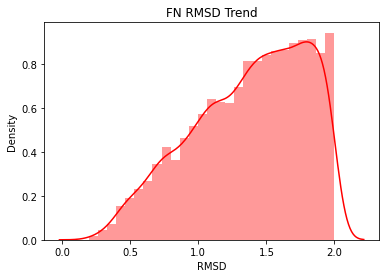

In [46]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title("FN RMSD Trend")
rmsdContFigs = sns.distplot(fnRmsds0To2w, axlabel='RMSD', color="red", ax=ax)
#sns.distplot(fnRmsds0To2r, axlabel='RMSD', color="blue", ax=ax)

In [47]:
rmsdContFigs.get_figure().savefig('./FN.png', dpi=400)

In [27]:
for i, rmsd in enumerate(fnRmsds2To10):
    if rmsd >= 7.5 and rmsd <= 8:
        print(predFalseDf.iloc[i])

Unnamed: 0       3
file_name     5mjn
label            0
Name: 3, dtype: object
Unnamed: 0      13
file_name     5u11
label            0
Name: 13, dtype: object
Unnamed: 0      74
file_name     3lzu
label            0
Name: 74, dtype: object
Unnamed: 0              172
file_name     4lxz_ligand_2
label                     1
Name: 172, dtype: object
Unnamed: 0              178
file_name     5ioz_ligand_5
label                     1
Name: 178, dtype: object
Unnamed: 0              206
file_name     4w9p_ligand_4
label                     1
Name: 206, dtype: object
Unnamed: 0              291
file_name     6gf9_ligand_7
label                     1
Name: 291, dtype: object
